# Import libraries

In [ ]:
!pip install bertopic[gensim]
from bertopic import BERTopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 1.9 MB/s 
     |████████████████████████████████| 88 kB 3.9 MB/s 
     |████████████████████████████████| 79 kB 6.2 MB/s 
     |████████████████████████████████| 5.2 MB 48.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 24.1 MB 1.4 MB/s 
     |████████████████████████████████| 4.4 MB 15.5 MB/s 
     |████████████████████████████████| 1.2 MB 62.5 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 6.6 MB 52.4 MB/s 
     |████████████████████████████████| 636 kB 73.1 MB/s 
     |████████████████████████████████| 1.1 MB 71.4 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2342184 sha256=9dafa42b46008cc4c9130e080e3cb1afbcfffcadaf46

In [ ]:
import pandas as pd
!pip install -U numpy
import numpy as np
import spacy

import re
import seaborn as sns 
from matplotlib import pyplot as plt

from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import ToktokTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load and preprocess data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/TFM_FINAL/scrapped_data.csv", index_col=0)
df = df[['readmes', 'label']]
#Remove duplicates
df = df.drop_duplicates()
df = df.dropna()
#Remove general
df = df[df['label'] != 'General']
df = df.reset_index(drop=True)

In [ ]:
aux = df[df.duplicated(subset='readmes', keep=False)]

In [ ]:
#First we create a data frame without duplicates
duplicates = df[df.duplicated(subset='readmes', keep=False)]
no_duplicates =  df.drop_duplicates(subset='readmes', keep=False)

In [ ]:
#labels in ordered frequency (min to max)
labels = ['Audio', 'Graphs', 'Sequential', 'Reinforcement Learning', 'Natural Language Processing']
for lab in labels:
  add = duplicates[duplicates['label'] == lab]
  for i in add.index:
    if add['readmes'][i] not in no_duplicates['readmes']:
      no_duplicates = no_duplicates.append(add.loc[i])
no_duplicates = no_duplicates.reset_index(drop=True)

In [ ]:
def cleaner(text):
    """
    Preprocess the readmes
    """
    #Remove non-asci characters
    text = re.sub(r'\\x00|\\x01|\\x02|\\x03|\\x04|\\x05|\\x06|\\x07|\\x08|\\t|\\n|\\x0b|\\x0c|\\r|\\x0e|\\x0f|\\x10|\\x11|\\x12|\\x13|\\x14|\\x15|\\x16|\\x17|\\x18|\\x19|\\x1a|\\x1b|\\x1c|\\x1d|\\x1e|\\x1f|\\x7f|\\x80|\\x81|\\x82|\\x83|\\x84|\\x85|\\x86|\\x87|\\x88|\\x89|\\x8a|\\x8b|\\x8c|\\x8d|\\x8e|\\x8f|\\x90|\\x91|\\x92|\\x93|\\x94|\\x95|\\x96|\\x97|\\x98|\\x99|\\x9a|\\x9b|\\x9c|\\x9d|\\x9e|\\x9f|\\xa0|\\xa1|\\xa2|\\xa3|\\xa4|\\xa5|\\xa6|\\xa7|\\xa8|\\xa9|\\xaa|\\xab|\\xac|\\xad|\\xae|\\xaf|\\xb0|\\xb1|\\xb2|\\xb3|\\xb4|\\xb5|\\xb6|\\xb7|\\xb8|\\xb9|\\xba|\\xbb|\\xbc|\\xbd|\\xbe|\\xbf|\\xc0|\\xc1|\\xc2|\\xc3|\\xc4|\\xc5|\\xc6|\\xc7|\\xc8|\\xc9|\\xca|\\xcb|\\xcc|\\xcd|\\xce|\\xcf|\\xd0|\\xd1|\\xd2|\\xd3|\\xd4|\\xd5|\\xd6|\\xd7|\\xd8|\\xd9|\\xda|\\xdb|\\xdc|\\xdd|\\xde|\\xdf|\\xe0|\\xe1|\\xe2|\\xe3|\\xe4|\\xe5|\\xe6|\\xe7|\\xe8|\\xe9|\\xea|\\xeb|\\xec|\\xed|\\xee|\\xef|\\xf0|\\xf1|\\xf2|\\xf3|\\xf4|\\xf5|\\xf6|\\xf7|\\xf8|\\xf9|\\xfa|\\xfb|\\xfc|\\xfd|\\xfe|\\xff',
                  ' ',str(text))
    #Remove links
    text = re.sub(r'https:\S+',' ',text)
    #Remove beginning
    text = re.sub(r'(b\")|(b\')|(\\n)', ' ', text)
    #Remove html tags
    text = re.sub(r'<[^<]+>', ' ', text)
    #Remove code blocks
    text = re.sub(r'\`\`\`[^\`]+\`\`\`', ' ', text)
    #Remove new line characters
    text = text.rstrip()
    #Remove inline code
    text = re.sub(r'\`[^\`]+\`', ' ',text)
    #Remove comands
    text = re.sub(r'--[\S]+ ', ' ',text)
    #Remove paths from root
    text = re.sub(r'C:\\\S', ' ',text)
    #Remove paths
    #2 CONSIDERA: todos los caracteres que no sean <, > , : , " , / , \ , | , ? , * o espacio (prohibidos en windows)
    #  Ejemplo : /path_to/#coco/
    #  NO CONSIDERA:  carpeta/archivo final, en linux el único caracter prohibido es /
    text = re.sub(r'([^\<\>\:\"\/\|\?\*\s]+\/)+',' ', text)
    #Remove file names 
    text = re.sub(r'([^\<\>\:\"\/\|\?\*\s]+)\.(ipynb|py|sh|dll|exe|txt|mp4|mp3|cfg|config|avi|cmd|tar.gz)', ' ', text)
    #Remove common abbreviations
    text = re.sub(r'i\.e\.|e\.g\.|etc.',' ',text)
    #Remove special characters
    text = re.sub(r'[^a-zA-Z0-9]',' ',text)
    #Remove nones
    text = re.sub(r'[Nn]one',' ',text)
    #Remove numbers (not included in words)
    text = re.sub('[0-9]+\s',' ',text)
    #Remove words with only one character
    text = re.sub(r'\b\w{1,2}\b',' ',text)
    #Substitute long space for one space
    text = re.sub(r'\s+',' ', text, flags=re.I)
    #Change text to lower case
    text = text.lower()
    return text

In [ ]:
df = no_duplicates.copy()
df['text'] = df['readmes'].apply(cleaner)

In [ ]:
#Tokenize
tokenizer = ToktokTokenizer() 
df['Tokens'] = df['text'].apply(tokenizer.tokenize)
df = df[df.Tokens.str.len() > 2]
df = df.reset_index(drop=True)
docs = df['text']
diccionario = Dictionary(df['Tokens'])

In [ ]:
docs

0        psis data augmentation for object detection v...
1        sniper autofocus efficient multi scale traini...
2        sniper efficient multi scale training sniper ...
3        english readme img src href src img src img s...
4        model based papers papers list word discovery...
                              ...                        
8320     pytorch tensorflow tripnet recognition instru...
8321     pytorch tensorflow attention tripnet exploiti...
8322     this folder includes cholect dataset data cho...
8323     pypi version ivtmetrics the ivtmetrics librar...
8324     perspective taking and pragmatics for generat...
Name: text, Length: 8325, dtype: object

# Default

## all-MiniLM-L6-v2

"BERTopic is a topic modeling technique that leverages BERT embeddings and c-TF-IDF to create dense clusters allowing for easily interpretable topics while keeping important words in the topic descriptions."

The default model in BERTopic ("all-MiniLM-L6-v2") works great for English documents

In [ ]:
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 123)
topic_model = BERTopic(umap_model=umap_model)
topics, probs = topic_model.fit_transform(docs)
info = topic_model.get_topic_info()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
info

,Topic,Count,Name
0,-1,2487,-1_the_and_for_model
1,0,693,0_agent_environment_reinforcement_policy
2,1,289,1_graph_node_gcn_graphs
3,2,271,2_attention_transformer_translation_sequence
4,3,218,3_gan_generator_adversarial_discriminator
...,...,...,...
124,123,11,123_bart_categories_category_pet
125,124,10,124_fpn_poto_800size_cvpr
126,125,10,125_privacy_lesson_sign_project
127,126,10,126_cloudy_sunny_anime_wat


In [ ]:
words_per_topic = []
for i in range(len(info)-1):
  tups = topic_model.get_topic(i)
  words_per_topic.append(list(list(zip(*tups))[0]))

In [ ]:
umass_bert = CoherenceModel(topics=words_per_topic, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_bert = CoherenceModel(topics=words_per_topic, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
umass_cv = umass_bert.get_coherence()

In [ ]:
npmi_cv = npmi_bert.get_coherence()

In [ ]:
print('UMASS of "all-MiniLM-L6-v2" model:', umass_cv)
print('NPMI of "all-MiniLM-L6-v2" model:', npmi_cv)

UMASS of "all-MiniLM-L6-v2" model: -3.3553787970738345
NPMI of "all-MiniLM-L6-v2" model: 0.06943338310382358


## all-mpnet-base-v2

In [ ]:
vectorizer_model = CountVectorizer(stop_words="english")
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 9800)
sentence_model = SentenceTransformer("all-mpnet-base-v2")

topic_model_5 = BERTopic(vectorizer_model = vectorizer_model,
                         embedding_model=sentence_model,
                         umap_model=umap_model
                        )

topics, probs = topic_model_5.fit_transform(docs)
info_5 = topic_model_5.get_topic_info()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
words_per_topic_5 = []
for i in range(len(info_5)-1):
  tups = topic_model_5.get_topic(i)
  words_per_topic_5.append(list(list(zip(*tups))[0]))

In [ ]:
umass_bert_5 = CoherenceModel(topics=words_per_topic_5, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_bert_5 = CoherenceModel(topics=words_per_topic_5, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
umass_mpnet_5 = umass_bert_5.get_coherence()
npmi_mpnet_5 = npmi_bert_5.get_coherence()

In [ ]:
print('UMASS of M5:', umass_mpnet_5)
print('NPMI of M5:', npmi_mpnet_5)

UMASS of M5: -4.409124238431884
NPMI of M5: 0.0560802906179405


In [ ]:
info_5

,Topic,Count,Name
0,-1,2409,-1_training_model_image_use
1,0,281,0_segmentation_net_unet_dice
2,1,277,1_translation_attention_transformer_decoder
3,2,224,2_learning_machine_clnet_deep
4,3,139,3_vae_variational_latent_mnist
...,...,...,...
163,162,11,162_ctc_speech_keyword_streaming
164,163,11,163_wheat_snip_size_spike
165,164,11,164_ganzo_epoch_defines_options
166,165,10,165_graph_zinc_smp_gnn


## allenai-specter

In [ ]:
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 9800)
sentence_model = SentenceTransformer("allenai-specter")

topic_model_7 = BERTopic(vectorizer_model=vectorizer_model,
                         embedding_model=sentence_model,
                        )

topics, probs = topic_model_7.fit_transform(docs)
info_7 = topic_model_7.get_topic_info()

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/622 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

In [ ]:
words_per_topic_7 = []
for i in range(len(info_7)-1):
  tups = topic_model_7.get_topic(i)
  words_per_topic_7.append(list(list(zip(*tups))[0]))

In [ ]:
info_7

,Topic,Count,Name
0,-1,2454,-1_learning_model_data_training
1,0,449,0_detection_object_yolov_coco
2,1,248,1_segmentation_nbsp nbsp nbsp_nbsp nbsp_semantic
3,2,202,2_segmentation_net_unet_brain
4,3,190,3_block_type_open colab_weight
...,...,...,...
127,126,11,126_yolo_voc_voc model_obj
128,127,11,127_squeezenet_modelhub_fbnet_viewed
129,128,10,128_minority_synthetic_sampling_imbalanced
130,129,10,129_usage_attention_usage paper_usage code


In [ ]:
umass_bert_7 = CoherenceModel(topics=words_per_topic_7, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_bert_7 = CoherenceModel(topics=words_per_topic_7, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
umass_spect_7 = umass_bert_7.get_coherence()
npmi_spect_7 = npmi_bert_7.get_coherence()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
print('UMASS of M7:', umass_spect_7)
print('NPMI of M7:', npmi_spect_7)

UMASS of M7: nan
NPMI of M7: nan


# Min_cluster_size=50

## all-MiniLM-L6-v2

In [ ]:
#1 min
vectorizer_model = CountVectorizer(stop_words="english")
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 123)
topic_model_all_2 = BERTopic(vectorizer_model = vectorizer_model,
                         umap_model=umap_model,
                         min_topic_size = 50)
topics, probs = topic_model_all_2.fit_transform(docs)
info_all_2 = topic_model_all_2.get_topic_info()

In [ ]:
info_all_2

,Topic,Count,Name
0,-1,1722,-1_yolo_training_image_model
1,0,1394,0_bert_model_text_word
2,1,875,1_gan_images_generator_image
3,2,805,2_resnet_model_cifar_imagenet
4,3,691,3_agent_environment_learning_reinforcement
5,4,352,4_audio_speech_wavenet_speaker
6,5,349,5_cnn_faster_rcnn_mask
7,6,335,6_yolov_yolo_detection_nbsp
8,7,289,7_graph_node_networks_gcn
9,8,239,8_transformer_vit_swin_attention


In [ ]:
words_per_topic_all_2 = []
for i in range(len(info_all_2)-1):
  tups = topic_model_all_2.get_topic(i)
  words_per_topic_all_2.append(list(list(zip(*tups))[0]))

In [ ]:
umass_all_2 = CoherenceModel(topics=words_per_topic_all_2, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_all_2 = CoherenceModel(topics=words_per_topic_all_2, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
vumass_all_2 = umass_all_2.get_coherence()

In [ ]:
vnpmi_all_2 = npmi_all_2.get_coherence()

In [ ]:
print('UMASS of all-MiniLM-L6-v2, minimum cluster size=50:', vumass_all_2)
print('NPMI of all-MiniLM-L6-v2, minimum cluster size=50:', vnpmi_all_2)

UMASS of all-MiniLM-L6-v2, minimum cluster size=50: -1.8107468830631424
NPMI of all-MiniLM-L6-v2, minimum cluster size=50: 0.0966729788026776


## all-mpnet-base-v2

In [ ]:
#3 min
vectorizer_model = CountVectorizer(stop_words="english")
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 9800)
sentence_model = SentenceTransformer("all-mpnet-base-v2")

topic_model_mpnet_2 = BERTopic(vectorizer_model=vectorizer_model,
                         embedding_model=sentence_model,
                         umap_model=umap_model,
                         calculate_probabilities = False,
                         min_topic_size=50
                        )

topics, probs = topic_model_mpnet_2.fit_transform(docs)
info_mpnet_2 = topic_model_mpnet_2.get_topic_info()

In [ ]:
words_per_topic_mpnet_2 = []
for i in range(len(info_mpnet_2)-1):
  tups = topic_model_mpnet_2.get_topic(i)
  words_per_topic_mpnet_2.append(list(list(zip(*tups))[0]))

In [ ]:
info_mpnet_2

,Topic,Count,Name
0,-1,2398,-1_model_training_data_use
1,0,960,0_gan_images_image_generator
2,1,692,1_agent_environment_learning_reinforcement
3,2,409,2_ssd_cnn_faster_detection
4,3,354,3_audio_speech_wavenet_speaker
5,4,328,4_resnet_cifar_imagenet_residual
6,5,295,5_graph_node_networks_graphs
7,6,274,6_translation_attention_transformer_sequence
8,7,263,7_segmentation_semantic_image_dataset
9,8,243,8_segmentation_net_image_unet


In [ ]:
umass_mpnet_2 = CoherenceModel(topics=words_per_topic_mpnet_2, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_mpnet_2 = CoherenceModel(topics=words_per_topic_mpnet_2, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
vumass_mpnet_2 = umass_mpnet_2.get_coherence()
vnpmi_mpnet_2 = npmi_mpnet_2.get_coherence()

In [ ]:
print('UMASS of all-mpnet-base-v2, minimum cluster size=50:', vumass_mpnet_2)
print('NPMI of all-mpnet-base-v2, minimum cluster size=50:', vnpmi_mpnet_2)

UMASS of all-mpnet-base-v2, minimum cluster size=50: -1.9257306308056263
NPMI of all-mpnet-base-v2, minimum cluster size=50: 0.10277188349920222


## allenai-specter

In [ ]:
#4 min
vectorizer_model = CountVectorizer(stop_words="english")
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 9800)
sentence_model = SentenceTransformer("allenai-specter")

topic_model_spect_2 = BERTopic(vectorizer_model=vectorizer_model,
                         embedding_model=sentence_model,
                         umap_model=umap_model,
                         calculate_probabilities = False,
                         min_topic_size=50
                        )

topics, probs = topic_model_spect_2.fit_transform(docs)
info_spect_2 = topic_model_spect_2.get_topic_info()

In [ ]:
words_per_topic_spect_2 = []
for i in range(len(info_spect_2)-1):
  tups = topic_model_spect_2.get_topic(i)
  words_per_topic_spect_2.append(list(list(zip(*tups))[0]))

In [ ]:
info_spect_2

,Topic,Count,Name
0,-1,1446,-1_yolo_training_image_model
1,0,1372,0_bert_model_language_text
2,1,1121,1_learning_model_resnet_training
3,2,827,2_clnet_python_yolov_type
4,3,670,3_agent_environment_learning_reinforcement
5,4,475,4_detection_object_coco_yolov
6,5,339,5_audio_speech_speaker_model
7,6,282,6_graph_node_networks_gcn
8,7,239,7_segmentation_nbsp_semantic_image
9,8,226,8_segmentation_net_image_images


In [ ]:
umass_spect_2 = CoherenceModel(topics=words_per_topic_spect_2, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_spect_2 = CoherenceModel(topics=words_per_topic_spect_2, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
vumass_spect_2 = umass_spect_2.get_coherence()
vnpmi_spect_2 = npmi_spect_2.get_coherence()

In [ ]:
print('UMASS of allenai-specter, minimum cluster size=50:', vumass_spect_2)
print('NPMI of allenai-specter, minimum cluster size=50:', vnpmi_spect_2)

UMASS of allenai-specter, minimum cluster size=50: -1.9716942600897323
NPMI of allenai-specter, minimum cluster size=50: 0.0877427834357772


# Min_cluster_size=100

## all-MiniLM-L6-v2

In [ ]:
#2 min
vectorizer_model = CountVectorizer(stop_words="english")
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 123)
topic_model_all_3 = BERTopic(vectorizer_model = vectorizer_model,
                         umap_model=umap_model,
                         min_topic_size = 100)
topics, probs = topic_model_all_3.fit_transform(docs)
info_all_3 = topic_model_all_3.get_topic_info()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
info_all_3

,Topic,Count,Name
0,0,3482,0_model_image_training_data
1,1,1475,1_model_bert_text_models
2,2,1071,2_images_gan_image_generator
3,-1,738,-1_yolo_map_weights_objects
4,3,691,3_agent_learning_environment_reinforcement
5,4,352,4_audio_speech_model_wavenet
6,5,289,5_graph_node_networks_gcn
7,6,126,6_vae_variational_latent_autoencoder
8,7,101,7_ssd_voc_http_model


In [ ]:
words_per_topic_all_3 = []
for i in range(len(info_all_3)-1):
  tups = topic_model_all_3.get_topic(i)
  words_per_topic_all_3.append(list(list(zip(*tups))[0]))

In [ ]:
umass_all_3 = CoherenceModel(topics=words_per_topic_all_3, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_all_3 = CoherenceModel(topics=words_per_topic_all_3, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
vumass_all_3 = umass_all_3.get_coherence()

In [ ]:
vnpmi_all_3 = npmi_all_3.get_coherence()

In [ ]:
print('UMASS of all-MiniLM-L6-v2, minimum cluster size=100:', vumass_all_3)
print('NPMI of all-MiniLM-L6-v2, minimum cluster size=100::', vnpmi_all_3)

UMASS of all-MiniLM-L6-v2, minimum cluster size=100: -1.0856821373205952
NPMI of all-MiniLM-L6-v2, minimum cluster size=100:: 0.09482604899084052


## all-mpnet-base-v2

In [ ]:
#4 min
vectorizer_model = CountVectorizer(stop_words="english")
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 9800)
sentence_model = SentenceTransformer("all-mpnet-base-v2")

topic_model_mpnet_3 = BERTopic(vectorizer_model=vectorizer_model,
                         embedding_model=sentence_model,
                         umap_model=umap_model,
                         calculate_probabilities = False,
                         min_topic_size=100
                        )

topics, probs = topic_model_mpnet_3.fit_transform(docs)
info_mpnet_3 = topic_model_mpnet_3.get_topic_info()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
words_per_topic_mpnet_3 = []
for i in range(len(info_mpnet_3)-1):
  tups = topic_model_mpnet_3.get_topic(i)
  words_per_topic_mpnet_3.append(list(list(zip(*tups))[0]))

In [ ]:
info_mpnet_3

,Topic,Count,Name
0,0,5320,0_model_training_data_use
1,1,1372,1_image_images_gan_training
2,2,692,2_agent_learning_environment_reinforcement
3,3,354,3_audio_speech_model_wavenet
4,4,295,4_graph_networks_node_learning
5,-1,149,-1_pointnet_point_data_model
6,5,143,5_face_model_dataset_recognition


In [ ]:
umass_mpnet_3 = CoherenceModel(topics=words_per_topic_mpnet_3, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_mpnet_3 = CoherenceModel(topics=words_per_topic_mpnet_3, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
vumass_mpnet_3 = umass_mpnet_3.get_coherence()
vnpmi_mpnet_3 = npmi_mpnet_3.get_coherence()

In [ ]:
print('UMASS of all-mpnet-base-v2, minimum cluster size=100:', vumass_mpnet_3)
print('NPMI of all-mpnet-base-v2, minimum cluster size=100:', vnpmi_mpnet_3)

UMASS of all-mpnet-base-v2, minimum cluster size=100: -1.2950114118515907
NPMI of all-mpnet-base-v2, minimum cluster size=100: 0.08294202633733765


## allenai-specter

In [ ]:
#4 min
vectorizer_model = CountVectorizer(stop_words="english")
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 9800)
sentence_model = SentenceTransformer("allenai-specter")

topic_model_spect_3 = BERTopic(vectorizer_model=vectorizer_model,
                         embedding_model=sentence_model,
                         umap_model=umap_model,
                         calculate_probabilities = False,
                         min_topic_size=100
                        )

topics, probs = topic_model_spect_3.fit_transform(docs)
info_spect_3 = topic_model_spect_3.get_topic_info()

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/622 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

In [ ]:
words_per_topic_spect_3 = []
for i in range(len(info_spect_3)-1):
  tups = topic_model_spect_3.get_topic(i)
  words_per_topic_spect_3.append(list(list(zip(*tups))[0]))

In [ ]:
info_spect_3

,Topic,Count,Name
0,0,5363,0_model_image_training_images
1,1,1372,1_model_bert_text_models
2,2,670,2_agent_learning_environment_reinforcement
3,3,339,3_audio_speech_model_training
4,-1,299,-1_yolo_map_objects_detection
5,4,282,4_graph_node_networks_gcn


In [ ]:
umass_spect_3 = CoherenceModel(topics=words_per_topic_spect_3, texts=df.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_spect_3 = CoherenceModel(topics=words_per_topic_spect_3, texts=df.Tokens, dictionary=diccionario,coherence='c_npmi')

In [ ]:
vumass_spect_3 = umass_spect_3.get_coherence()
vnpmi_spect_3 = npmi_spect_3.get_coherence()

In [ ]:
print('UMASS of allenai-specter, minimum cluster size=100:', vumass_spect_3)
print('NPMI of allenai-specter, minimum cluster size=100:', vnpmi_spect_3)

UMASS of allenai-specter, minimum cluster size=100: -1.0682992234324473
NPMI of allenai-specter, minimum cluster size=100: 0.08676353421074022


# all-mini, min_cluster=100 analysis

In [ ]:
topics_per_class = topic_model_all_3.topics_per_class(docs,topics,classes=df['label'])

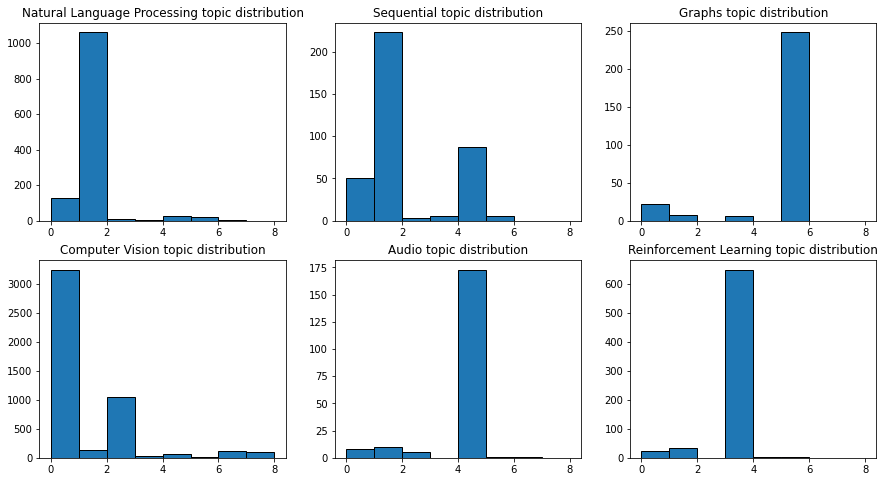

In [ ]:
plt.figure(figsize=(15,8))
topics_class = topics_per_class[topics_per_class['Topic'] != -1]
labels = topics_per_class['Class'].unique()
i = 1
for lab in labels:
  plt.subplot(2,3,i)
  i = i+1
  df2 = topics_per_class[topics_per_class['Class']==lab]
  df2.index = df2.Topic
  y = df2['Frequency'].reindex(range(0,8), fill_value=0)
  plt.bar(range(0,8), y, width=1, align='edge', edgecolor='black')
  plt.title(f'{lab} topic distribution')
plt.show()  

In [ ]:
topic_model_all_3.get_topics()

{-1: [('yolo', 0.06005490199601797),
  ('map', 0.030892362368160856),
  ('weights', 0.02986328688969706),
  ('objects', 0.029682045287313368),
  ('detection', 0.029355420073251304),
  ('use', 0.02800487215507104),
  ('training', 0.02789915415216027),
  ('file', 0.025934619418163798),
  ('train', 0.025213142267334163),
  ('coco', 0.02506975795325784)],
 0: [('model', 0.030962888296489667),
  ('image', 0.025187801603940917),
  ('training', 0.024577202365347103),
  ('data', 0.021527148979726282),
  ('dataset', 0.020751403687110617),
  ('images', 0.019538237730831392),
  ('learning', 0.018138249220564975),
  ('models', 0.017010402455578937),
  ('using', 0.01688812412449101),
  ('use', 0.01682599262982673)],
 1: [('model', 0.04229381834868977),
  ('bert', 0.039282933143730686),
  ('text', 0.02452564485572199),
  ('models', 0.023611239657301414),
  ('data', 0.023473655502068248),
  ('language', 0.02322682808356828),
  ('training', 0.02317213375092495),
  ('word', 0.022599132685691404),
  ('p

In [ ]:
topic_model_all_3.visualize_topics(range(0,8))